### Importing libraries

In [1]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
import pandas as pd
import numpy as np
import os, io
from surprise import KNNBasic, KNNWithMeans
from surprise import SVDpp
from surprise import SVD
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
ratings_df  = pd.read_csv('/Users/siri/Downloads/train.csv',delimiter="\t") #read csv into ratings_df dataframe
ratings_df.head()

,user_id,book_id,rating
0,12726,7784,5
1,23770,104293,4
2,15669,29291,4
3,649,420180,0
4,10980,7089179,0


In [3]:
ratings_df.isnull().values.any()  #checking if any null values are present in the datasset

False

In [4]:
ratings_df.describe()   

,user_id,book_id,rating
count,700000.000000,7.000000e+05,700000.000000
mean,18895.764374,4.970340e+06,2.644934
std,10745.949583,8.443227e+06,2.051200
min,0.000000,5.000000e+00,0.000000
25%,9558.000000,7.453200e+04,0.000000
50%,18986.000000,4.349280e+05,3.000000
75%,27946.000000,6.578293e+06,4.000000
max,37230.000000,3.645941e+07,5.000000


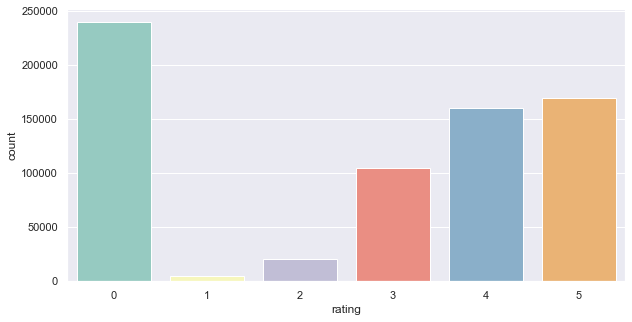

In [5]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
ax = sns.countplot(x="rating", data=ratings_df, palette="Set3")

In [6]:
ratings_new = ratings_df.drop_duplicates(subset = ['user_id', 'book_id'], keep = 'first')  #removing duplicate user-item entries

In [7]:
ratings_new.describe()   #count reduced to 699031 after removing duplicates

,user_id,book_id,rating
count,699031.000000,6.990310e+05,699031.000000
mean,18896.664847,4.961334e+06,2.645858
std,10746.700402,8.432186e+06,2.050950
min,0.000000,5.000000e+00,0.000000
25%,9558.000000,7.453200e+04,0.000000
50%,18986.000000,4.332310e+05,3.000000
75%,27946.000000,6.573878e+06,4.000000
max,37230.000000,3.645941e+07,5.000000


In [7]:
reader = Reader(rating_scale=(1,5))  #invoke reader instance of surprise library
data=Dataset.load_from_df(ratings_new,reader) #load dataset into Surprise datastructure Dataset

In [8]:
test_df=pd.read_csv("/Users/siri/Downloads/test.csv",delimiter="\t") # read test csv into test_df dataframe

In [64]:
ratings_new.shape, test_df.shape  #checking the shape of train test datasets

((699031, 3), (299606, 3))

In [65]:
num_users=ratings_new.user_id.nunique()     #finding the number of unique books and users
num_books=ratings_new.book_id.nunique()
print("number of unique users", num_users)
print("number of unique books", num_books)

number of unique users 35280
number of unique books 68371


In [8]:
no_of_ratings_per_book=ratings_new.groupby('book_id')['rating'].count()          #finding the number of ratings for each book
no_of_ratings_per_book

book_id
5           11204
50           1293
61             30
93           1173
236            11
            ...  
36365373        2
36372214        2
36381441        1
36391470        1
36459407        1
Name: rating, Length: 68371, dtype: int64

Text(0.5, 1.0, 'Top 10 Books with highest ratings')

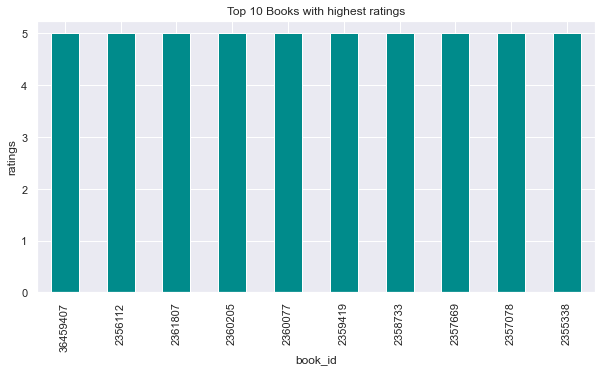

In [9]:
ratings_new.groupby('book_id')['rating'].max().sort_values(ascending=False).head(10).plot(kind='bar',figsize=(10,5),color='darkcyan')
plt.ylabel('ratings')
plt.title('Top 10 Books with highest ratings')

In [9]:
test_df.loc[:, 'rating'] = 0 #adding a dummy column rating in the test set to load into Surprise datastructure Dataset
test_set = Dataset.load_from_df(test_df, reader=reader)
test_set = test_set.build_full_trainset().build_testset()

In [10]:
data

##### GridSearchCV

In [112]:
param_grid = {'n_epochs': [30,50], 'lr_all': [0.01,0.02,0.03],         #setting hyperparameters for SVD 
              'reg_all': [0.1,0.2],'n_factors': [100,150]}

In [113]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)  #GridSearchCV with 5-fold CV


In [ ]:
gs.fit(data)

In [87]:
# best RMSE score
print(gs.best_score['rmse'])

1.5730448474844458


In [100]:
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

{'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.2, 'n_factors': 150}


In [101]:
# We can now use the algorithm that yields the best rmse:
svd = gs.best_estimator['rmse']
svd.fit(data.build_full_trainset())


In [102]:
predictions = svd.test(test_set)  #predict ratings on test set
est = [i.est for i in predictions] # retrieve the estimated ratings from prediction results.

In [103]:
predictions

[Prediction(uid=20989, iid=1832332, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=20989, iid=9410057, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=20989, iid=855915, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=20989, iid=1910120, r_ui=0.0, est=1.0704709355448332, details={'was_impossible': False}),
 Prediction(uid=20989, iid=885349, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=20989, iid=121490, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=20989, iid=25817074, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=20989, iid=348573, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=20989, iid=121408, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=20989, iid=1847199, r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=20989, iid=519312, r_ui=0.0, est=1, details={'was_impossible': False}),
 Predicti

In [104]:
pred_df = pd.DataFrame(predictions,columns=['user-id','book-id','r_ui','rating','details'])  #converting predictions to dataframe

In [105]:
pred_df.head()

,user-id,book-id,r_ui,rating,details
0,20989,1832332,0.0,1.000000,{'was_impossible': False}
1,20989,9410057,0.0,1.000000,{'was_impossible': False}
2,20989,855915,0.0,1.000000,{'was_impossible': False}
3,20989,1910120,0.0,1.070471,{'was_impossible': False}
4,20989,885349,0.0,1.000000,{'was_impossible': False}


In [106]:
pred_df=pred_df.drop(columns=['r_ui', 'details'])  #dropping dummy column r_ui and details column

##### formatting the data for final output file

In [107]:
pred_df['user-id']=pred_df['user-id'].astype(str)  
pred_df['book-id']=pred_df['book-id'].astype(str)
pred_df["user_id-book_id"] = pred_df[['user-id', 'book-id']].apply(lambda x: '-'.join(x), axis = 1)
pred_df.head()

,user-id,book-id,rating,user_id-book_id
0,20989,1832332,1.000000,20989-1832332
1,20989,9410057,1.000000,20989-9410057
2,20989,855915,1.000000,20989-855915
3,20989,1910120,1.070471,20989-1910120
4,20989,885349,1.000000,20989-885349


In [108]:
pred_df=pred_df.drop(columns=['user-id', 'book-id'])

In [109]:
column_names = ["user_id-book_id", "rating"]        
pred_df = pred_df.reindex(columns=column_names)    #changing the order of the dataframe columns

In [110]:
pred_df.head()

,user_id-book_id,rating
0,20989-1832332,1.000000
1,20989-9410057,1.000000
2,20989-855915,1.000000
3,20989-1910120,1.070471
4,20989-885349,1.000000


In [111]:
pred_df.to_csv(r'/Users/siri/Downloads/output_v9.csv', index = False, header=True)  #exporting dataframe to output csv file